In [457]:
## Imports

import math
import numpy as np
import pandas as pd
import scipy.stats

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [458]:
## Data Imports

train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Function Definition for getting feature types (categorical vs numerical)

In [459]:
def get_feature_groups():
    """ Returns a list of numerical and categorical features,
    excluding SalePrice and Id. """
    # Numerical Features
    num_features = train.select_dtypes(include=['int64','float64']).columns
    num_features = num_features.drop(['Id','SalePrice']) # drop ID and SalePrice

    # Categorical Features
    cat_features = train.select_dtypes(include=['object']).columns
    return list(num_features), list(cat_features)

num_features, cat_features = get_feature_groups()

## Analysis of numerical features

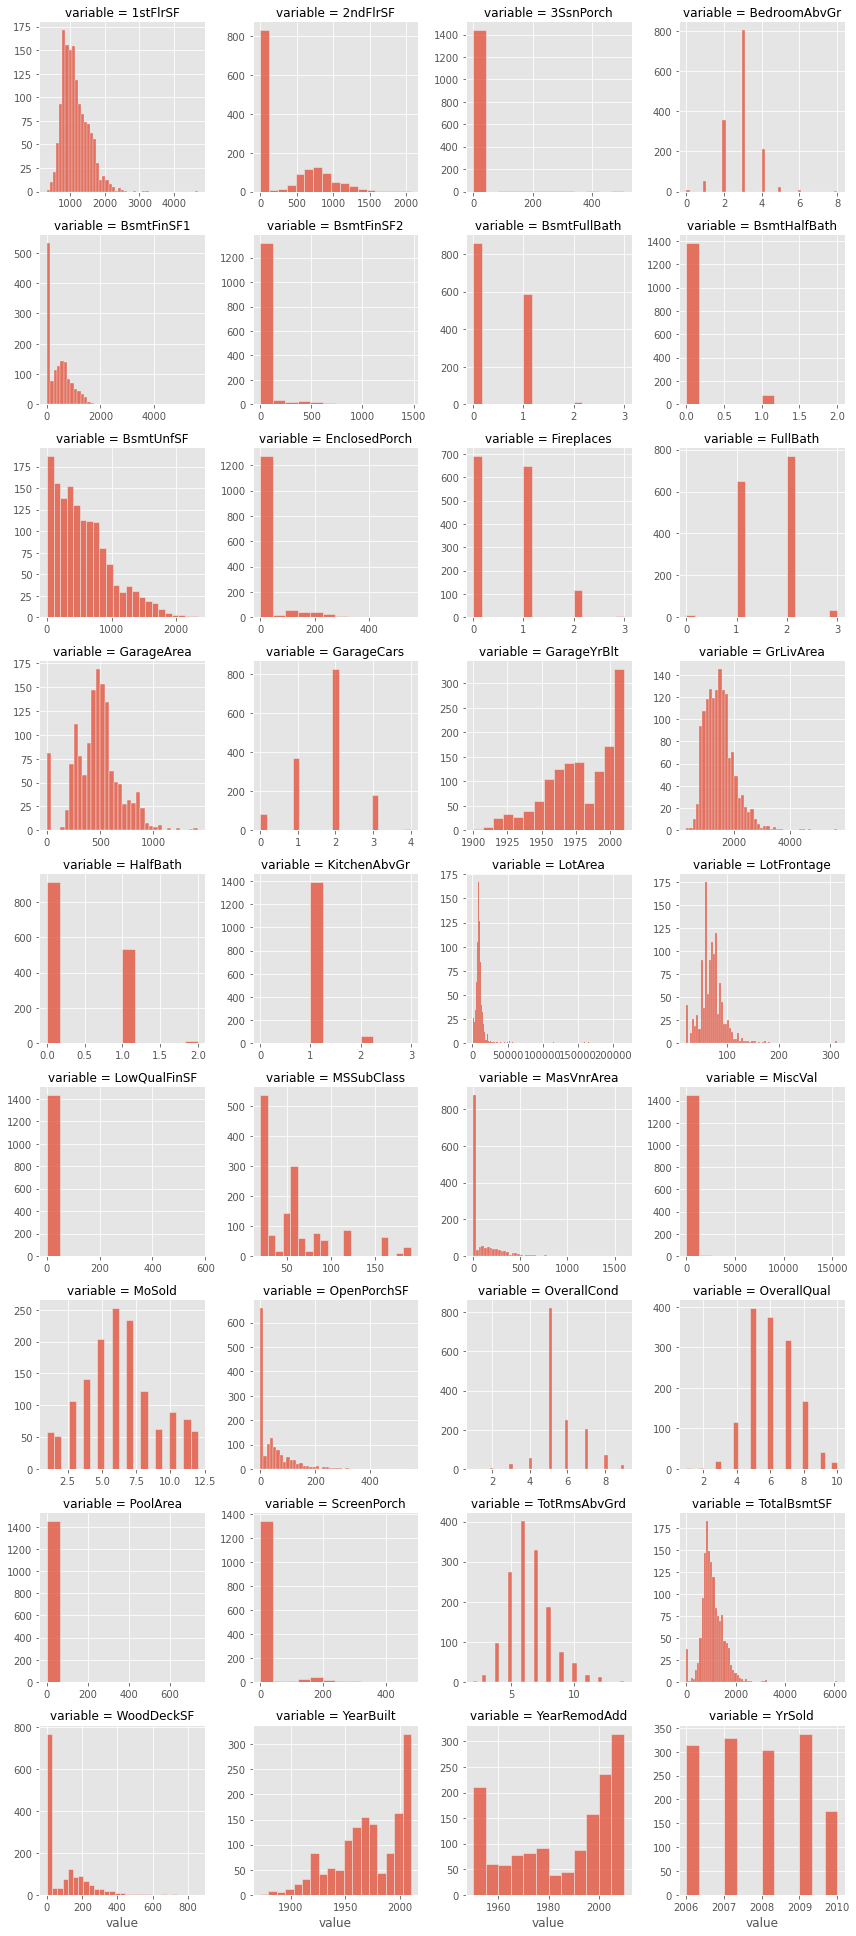

In [460]:
# Grid of distribution plots of all numerical features
f = pd.melt(train, value_vars=sorted(num_features))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.histplot, 'value')

# What does this tell us?

## Skewed Features

- Therea re many features that look positively skewed. We will log transform these. This list includes
    - LotFrontage
    - LotArea
    - BsmtUnfSF
    - TotalBsmtSF
    - 1stFlrSF
    - GrLivAre
    - Garage Area

- While there are many other features that are skewed in the same direction, we might not want to transform them as they are simply a count. I.e, number of bathrooms, Total Rooms Above Ground, etc.

## There are also a few features that have a large zero count. Like PoolValue. These types of variables are considered in the next plot.

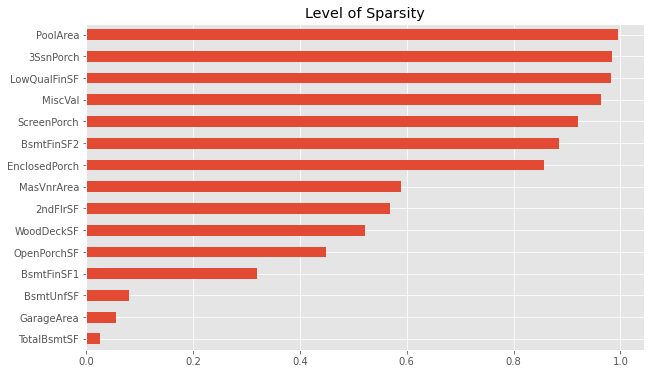

In [461]:
count_features = ['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',
                  'KitchenAbvGr','TotalRmsAbvGr','Fireplaces','GarageCars']
non_count_features = [f for f in num_features if f not in count_features]
sparse_features = (train[non_count_features] == 0).sum() / train.shape[0]
sparse_features[sparse_features > 0].\
    sort_values(ascending=True).\
    plot(kind='barh', figsize=(10,6))
plt.title('Level of Sparsity')
plt.show()

## The above shows the percentage of each feature that has a count of 0. We will have to remove the top 5 or so in our regression

In [462]:
# First off, earlier we said we'll need to transform
# a couple features to categorical. Since we're looking 
# at categorical data here, let's go ahead and do that now
# so they are included in the analysis.
train['MSSubClass'] = train.MSSubClass.apply(lambda x: str(x))
train['MoSold'] = train.MoSold.apply(lambda x: str(x))
train['YrSold'] = train.YrSold.apply(lambda x: str(x))

# Update our list of numerical and categorical features
num_features, cat_features = get_feature_groups()

c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


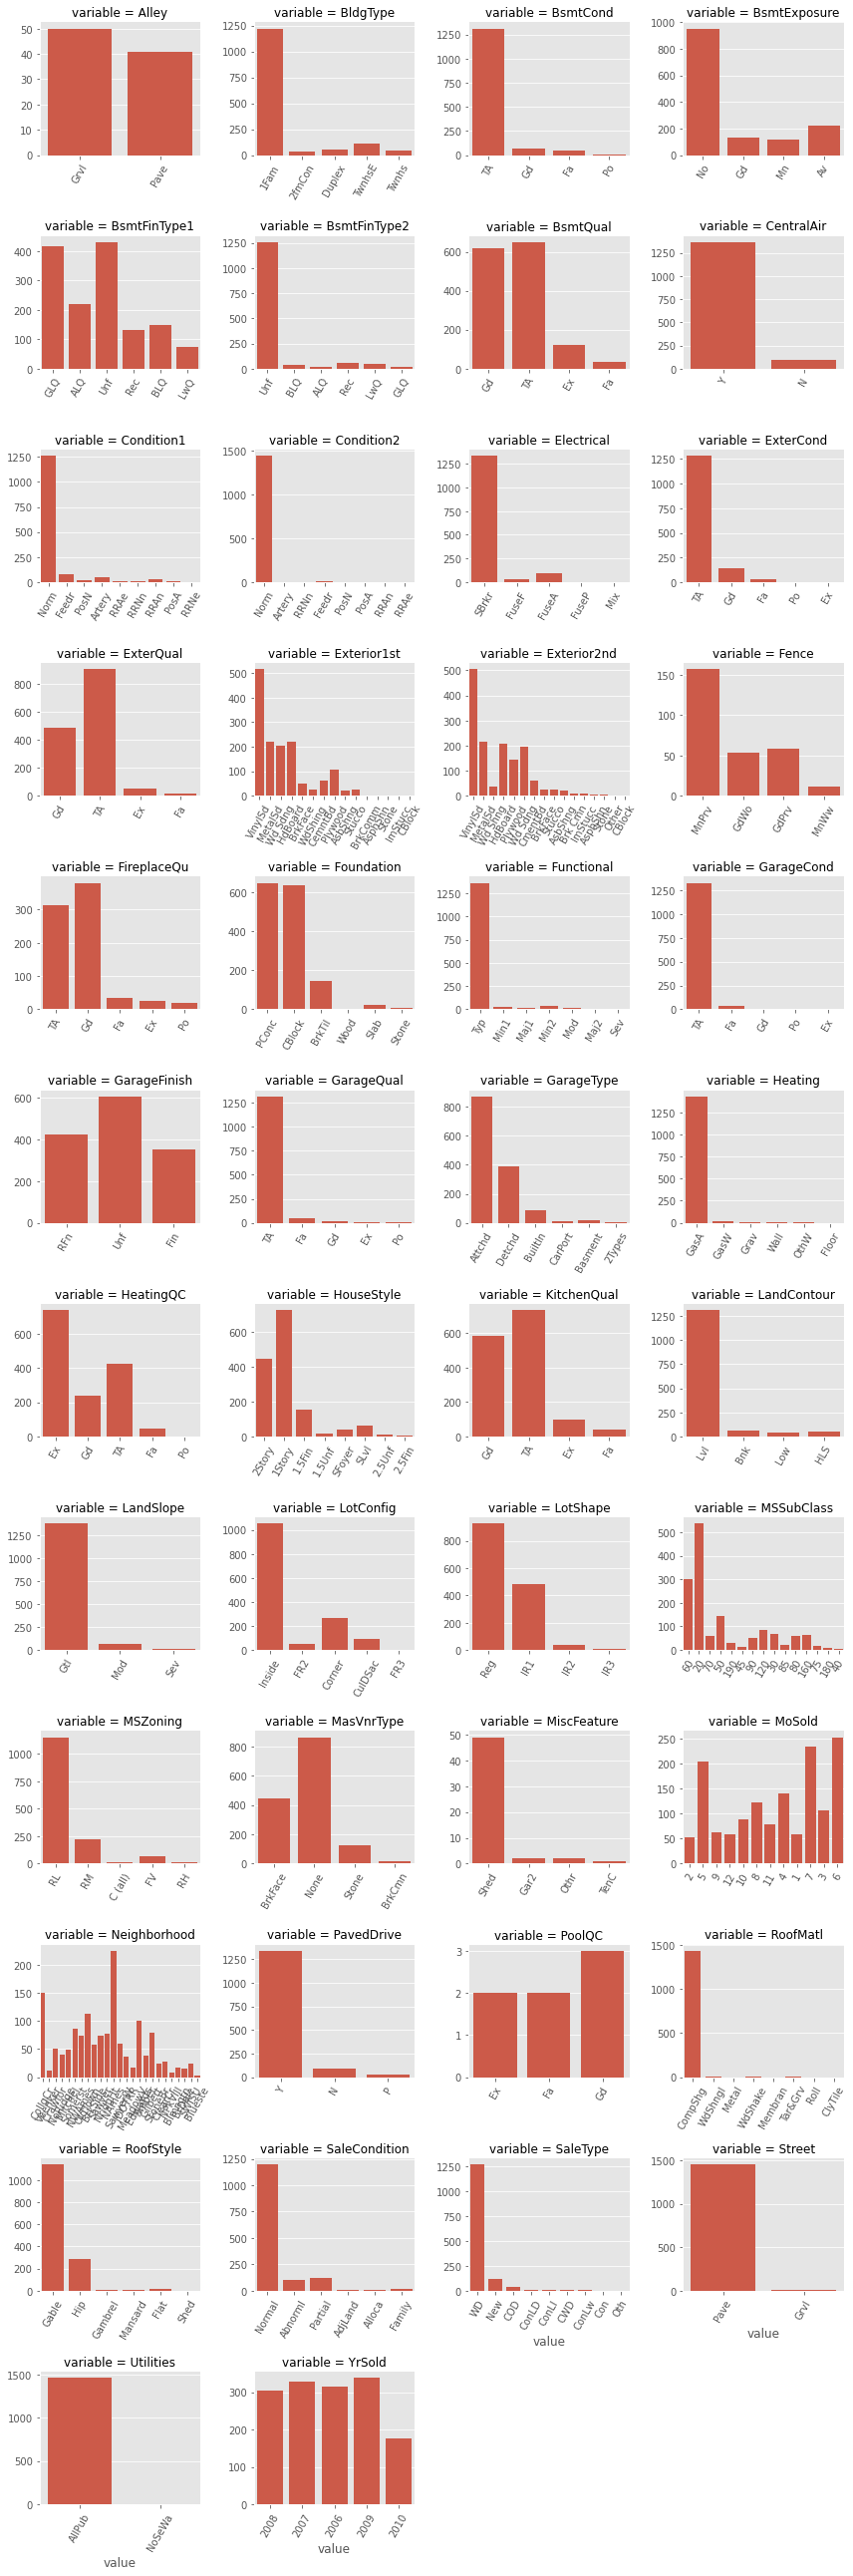

In [463]:
# Count plots of categorical features
f = pd.melt(train, value_vars=sorted(cat_features))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.countplot, 'value')
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

# What does this tell us?

- While it is important to note that there are a few categorical features like Condition 2, Sale Type, and Street, where one category is overly represented, we can leave those in as a potential way to identify outliers

- Another thing that stands out is that there are a number of categorical features that are actually rank information. Instead of these categories being purley categorical, we can change them to be on a scale of 1 to 5. The following features will get this treatment:

- Alley
- Lot Shape
- LandContour
- Utilities
- LandSlope
- ExterQual
- ExterCond
- BsmtQual
- BsmtCond
- BsmtExposure
- BsmtFinType1
- BsmtFinType2
- HeatingQC
- KitchenQual
- Functional
- FireplaceQu
- GarageFinish
- GarageQual
- GarageCond
- PavedDrive
- PoolQC

In [464]:
# Alley
train.Alley.replace({'Grvl':1, 'Pave':2}, inplace=True)

# Lot Shape
train.LotShape.replace({'Reg':1, 'IR1':2, 'IR2':3, 'IR3':4}, inplace=True)

# Land Contour
train.LandContour.replace({'Low':1, 'HLS':2, 'Bnk':3, 'Lvl':4}, inplace=True)

# Utilities
train.Utilities.replace({'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4}, inplace=True)

# Land Slope
train.LandSlope.replace({'Sev':1, 'Mod':2, 'Gtl':3}, inplace=True)

# Exterior Quality
train.ExterQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Exterior Condition
train.ExterCond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Basement Quality
train.BsmtQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Basement Condition
train.BsmtCond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Basement Exposure
train.BsmtExposure.replace({'No':1, 'Mn':2, 'Av':3, 'Gd':4}, inplace=True)

# Finished Basement 1 Rating
train.BsmtFinType1.replace({'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)

# Finished Basement 2 Rating
train.BsmtFinType2.replace({'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)

# Heating Quality and Condition
train.HeatingQC.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Kitchen Quality
train.KitchenQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Home functionality
train.Functional.replace({'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8}, inplace=True)

# Fireplace Quality
train.FireplaceQu.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Garage Finish
train.GarageFinish.replace({'Unf':1, 'RFn':2, 'Fin':3}, inplace=True)

# Garage Quality
train.GarageQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Garage Condition
train.GarageCond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Paved Driveway
train.PavedDrive.replace({'N':1, 'P':2, 'Y':3}, inplace=True)

# Pool Quality
train.PoolQC.replace({'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# We'll set all missing values in our newly converted features to 0
converted_features = ['Alley','LotShape','LandContour','Utilities','LandSlope','ExterQual','ExterCond',
        'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC',
        'KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual',
        'GarageCond','PavedDrive','PoolQC']
train[converted_features] = train[converted_features].fillna(0)

# Update our list of numerical and categorical features
num_features, cat_features = get_feature_groups()

## Numerical Features

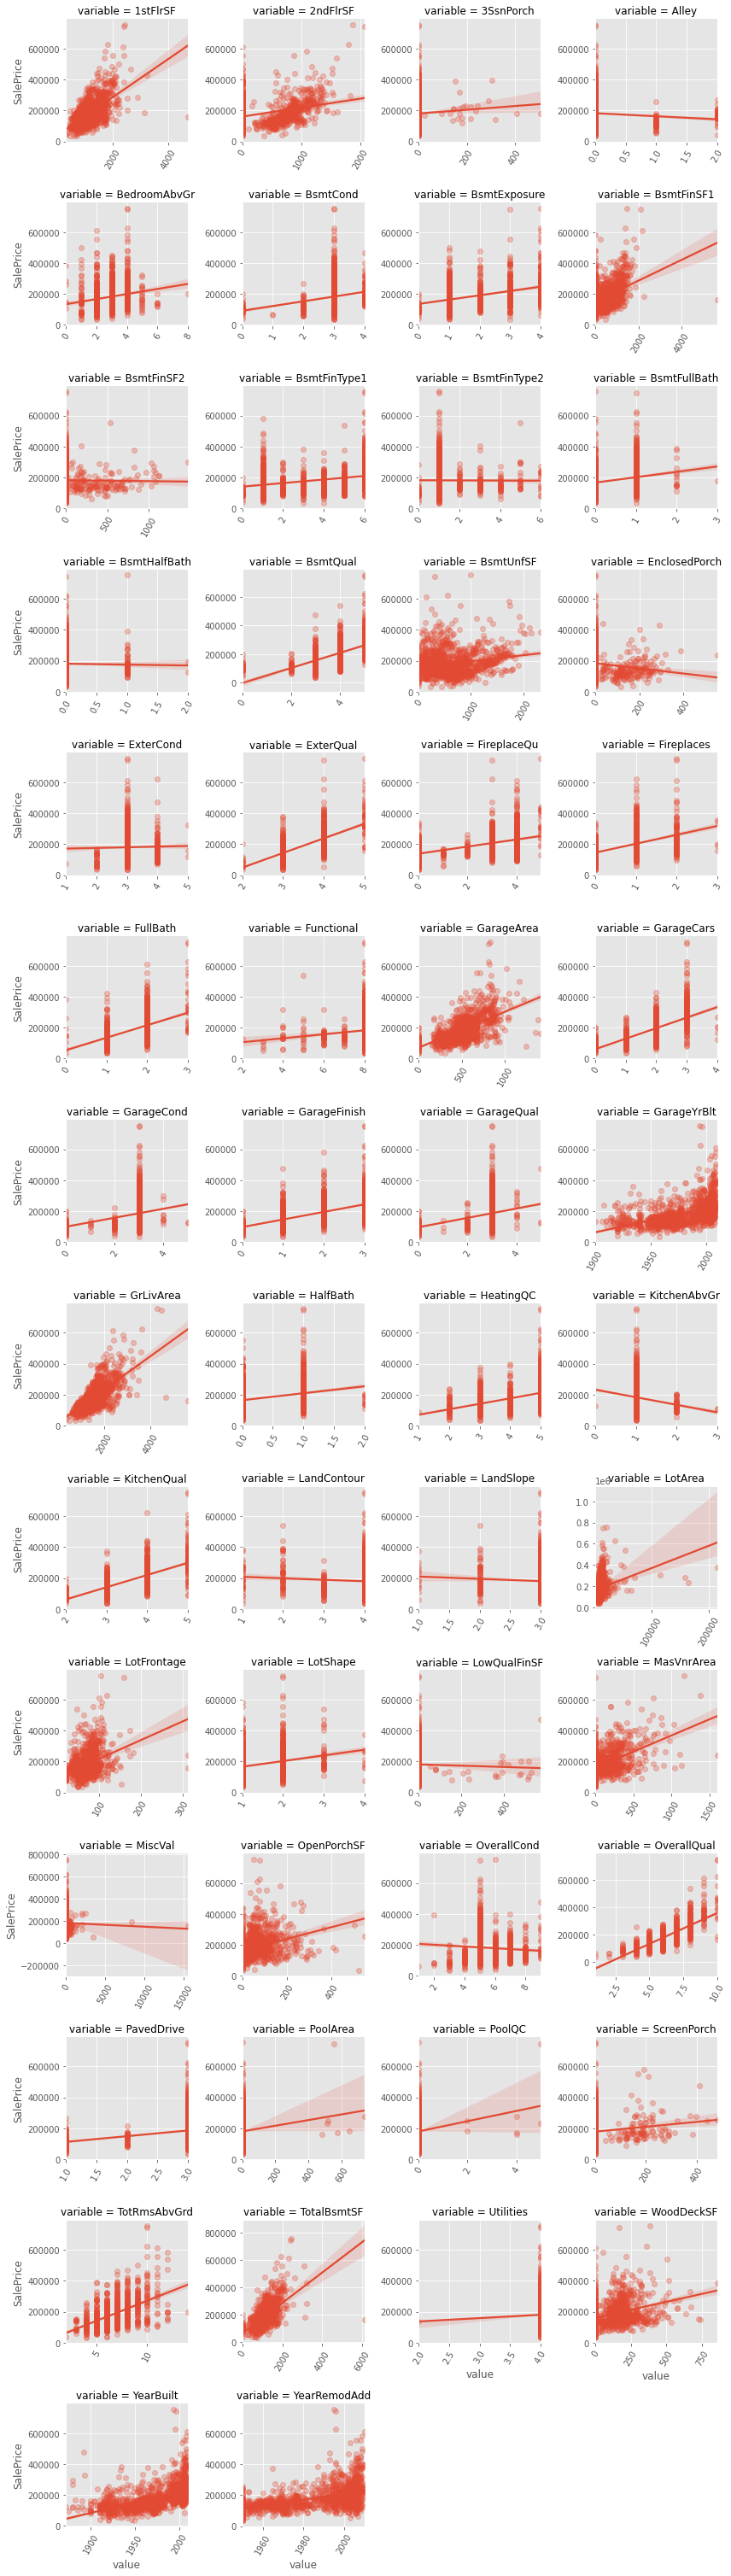

In [465]:
f = pd.melt(train, id_vars=['SalePrice'], value_vars=sorted(num_features))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.regplot, 'value', 'SalePrice', scatter_kws={'alpha':0.3})
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

## What do these plots of numerical features tell us?

- They confirm our intution that high quality, big houses, with big basements and lots of rooms are more expensive. 

- See variables: OverallQual, TotalBsmSF, GrLivArea, and TotRmsAbvGrd

## Skewness

- Also note the cone shapes in many of the plots. The cone shapes around the best fit line are a product of a skewed distribution. Below we will show the results of the listed variables after log transforming both the feature and the target variable SalePrice

c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


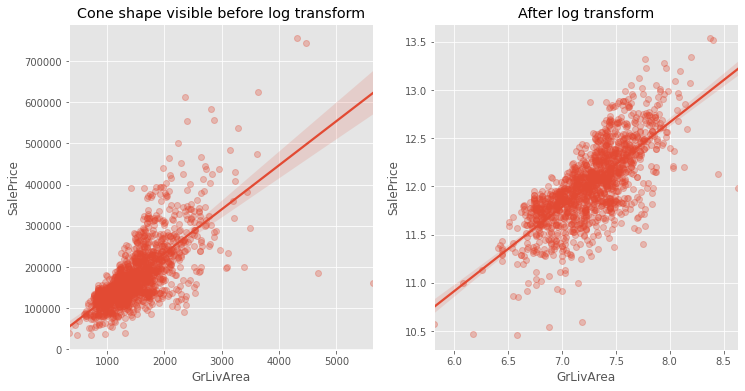

In [466]:
plt.figure(figsize=(12,6))
plt.subplot(121)
sns.regplot(train.GrLivArea, train.SalePrice, scatter_kws={'alpha':0.3})
plt.title('Cone shape visible before log transform')

plt.subplot(122)
sns.regplot(np.log1p(train.GrLivArea), np.log1p(train.SalePrice), scatter_kws={'alpha':0.3})
plt.title('After log transform')
plt.show()

c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


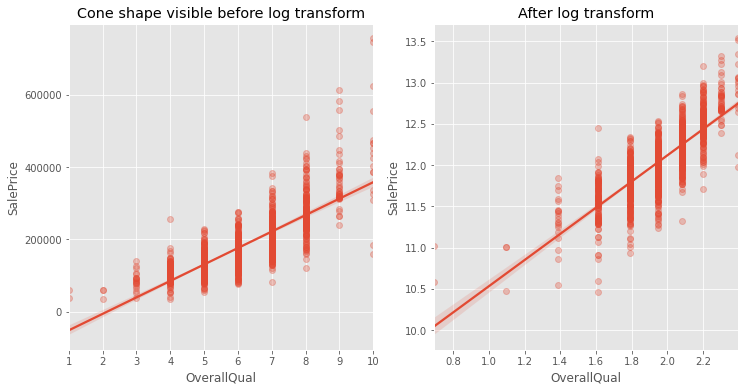

In [467]:
plt.figure(figsize=(12,6))
plt.subplot(121)
sns.regplot(train.OverallQual, train.SalePrice, scatter_kws={'alpha':0.3})
plt.title('Cone shape visible before log transform')

plt.subplot(122)
sns.regplot(np.log1p(train.OverallQual), np.log1p(train.SalePrice), scatter_kws={'alpha':0.3})
plt.title('After log transform')
plt.show()

c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


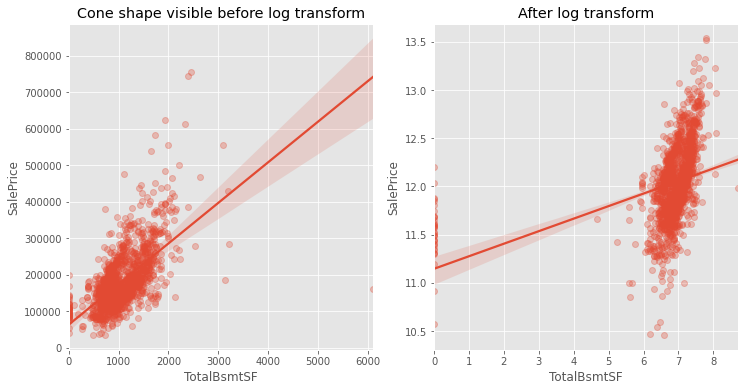

In [468]:
plt.figure(figsize=(12,6))
plt.subplot(121)
sns.regplot(train.TotalBsmtSF, train.SalePrice, scatter_kws={'alpha':0.3})
plt.title('Cone shape visible before log transform')

plt.subplot(122)
sns.regplot(np.log1p(train.TotalBsmtSF), np.log1p(train.SalePrice), scatter_kws={'alpha':0.3})
plt.title('After log transform')
plt.show()

c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


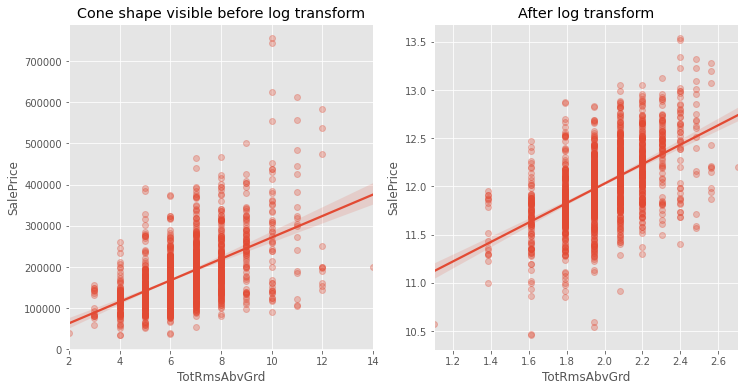

In [469]:
plt.figure(figsize=(12,6))
plt.subplot(121)
sns.regplot(train.TotRmsAbvGrd, train.SalePrice, scatter_kws={'alpha':0.3})
plt.title('Cone shape visible before log transform')

plt.subplot(122)
sns.regplot(np.log1p(train.TotRmsAbvGrd), np.log1p(train.SalePrice), scatter_kws={'alpha':0.3})
plt.title('After log transform')
plt.show()

## Now, we will evaluate the correlated between numerical features

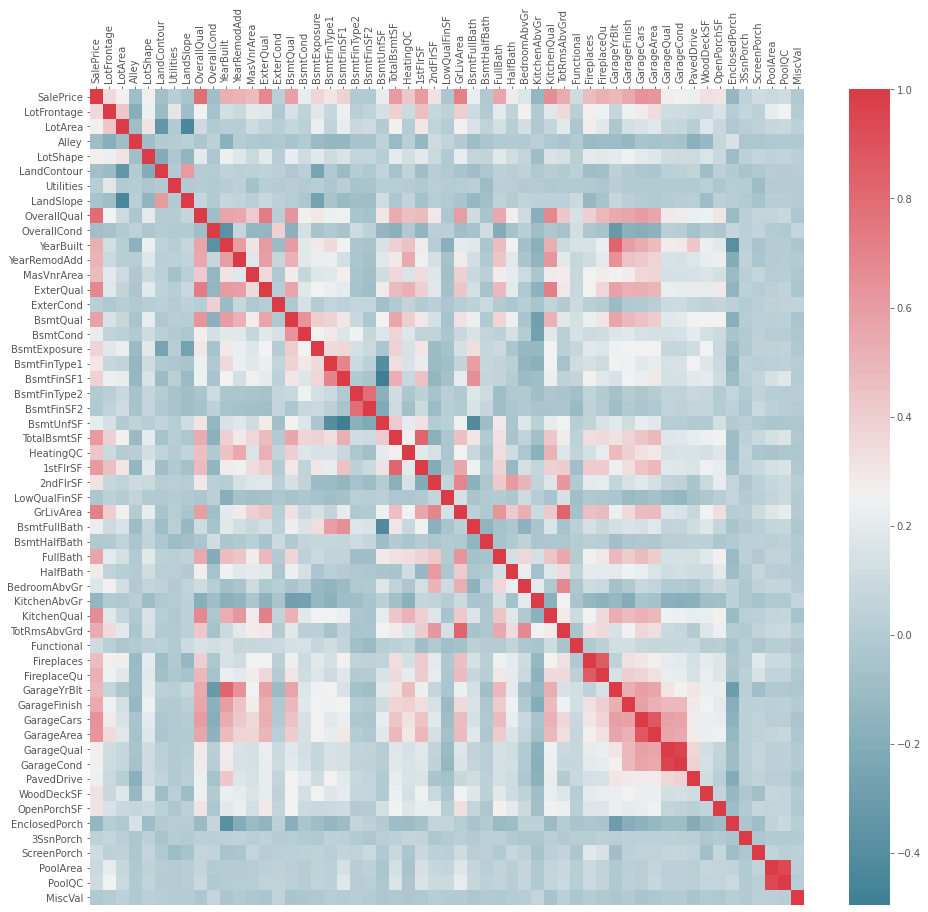

In [470]:
corr = train[['SalePrice'] + num_features].corr()
fig = plt.figure(figsize=(16,15))
ax = fig.add_subplot(111)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, 
           xticklabels=corr.columns.values,
           yticklabels=corr.index.values,
           cmap=cmap)
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

## What's Correlated? What's not?

- There are some features that you would expect to be correlated, and others that are more interesting.

1. GarageYrBlt is highly correlated with YearBuilt, which means that most Garages are not built after the fact, they are built with the home
2. BsmtQual highly correlates with OverallQual
3. TotalBsmtSF highly correlates with 1stFltSF
4. KitchenQual highly correlates with ExteriorQual. This is interesting because these are two seemingly discrete variables. However, there might be some hidden variable going on here. For example, if these houses are newer, perhaps you are more likely to have a better kitchen and exterior.
5. GrLivArea is highly correlated with TotRoomsAbvGrd. This is important because we identified these two as highly correlated with the response variable. We will likely have to make a decision on which one to keep

## What is the correlation with SalePrice

c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


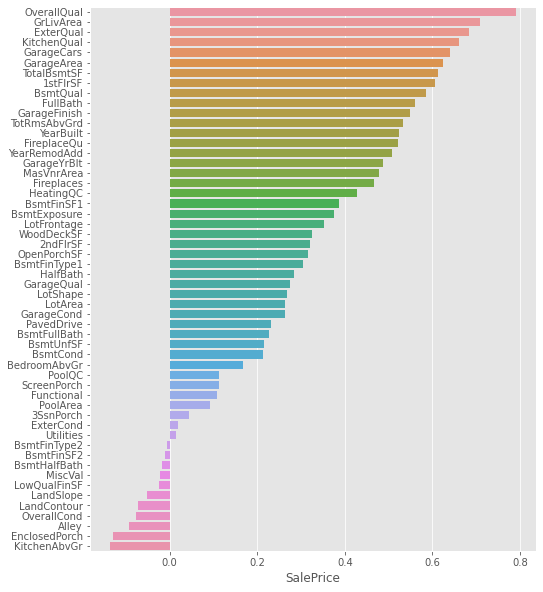

In [471]:
corr = corr.sort_values('SalePrice', ascending=False)
plt.figure(figsize=(8,10))
sns.barplot( corr.SalePrice[1:], corr.index[1:], orient='h')
plt.show()

## Boxplots for categorical features

c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


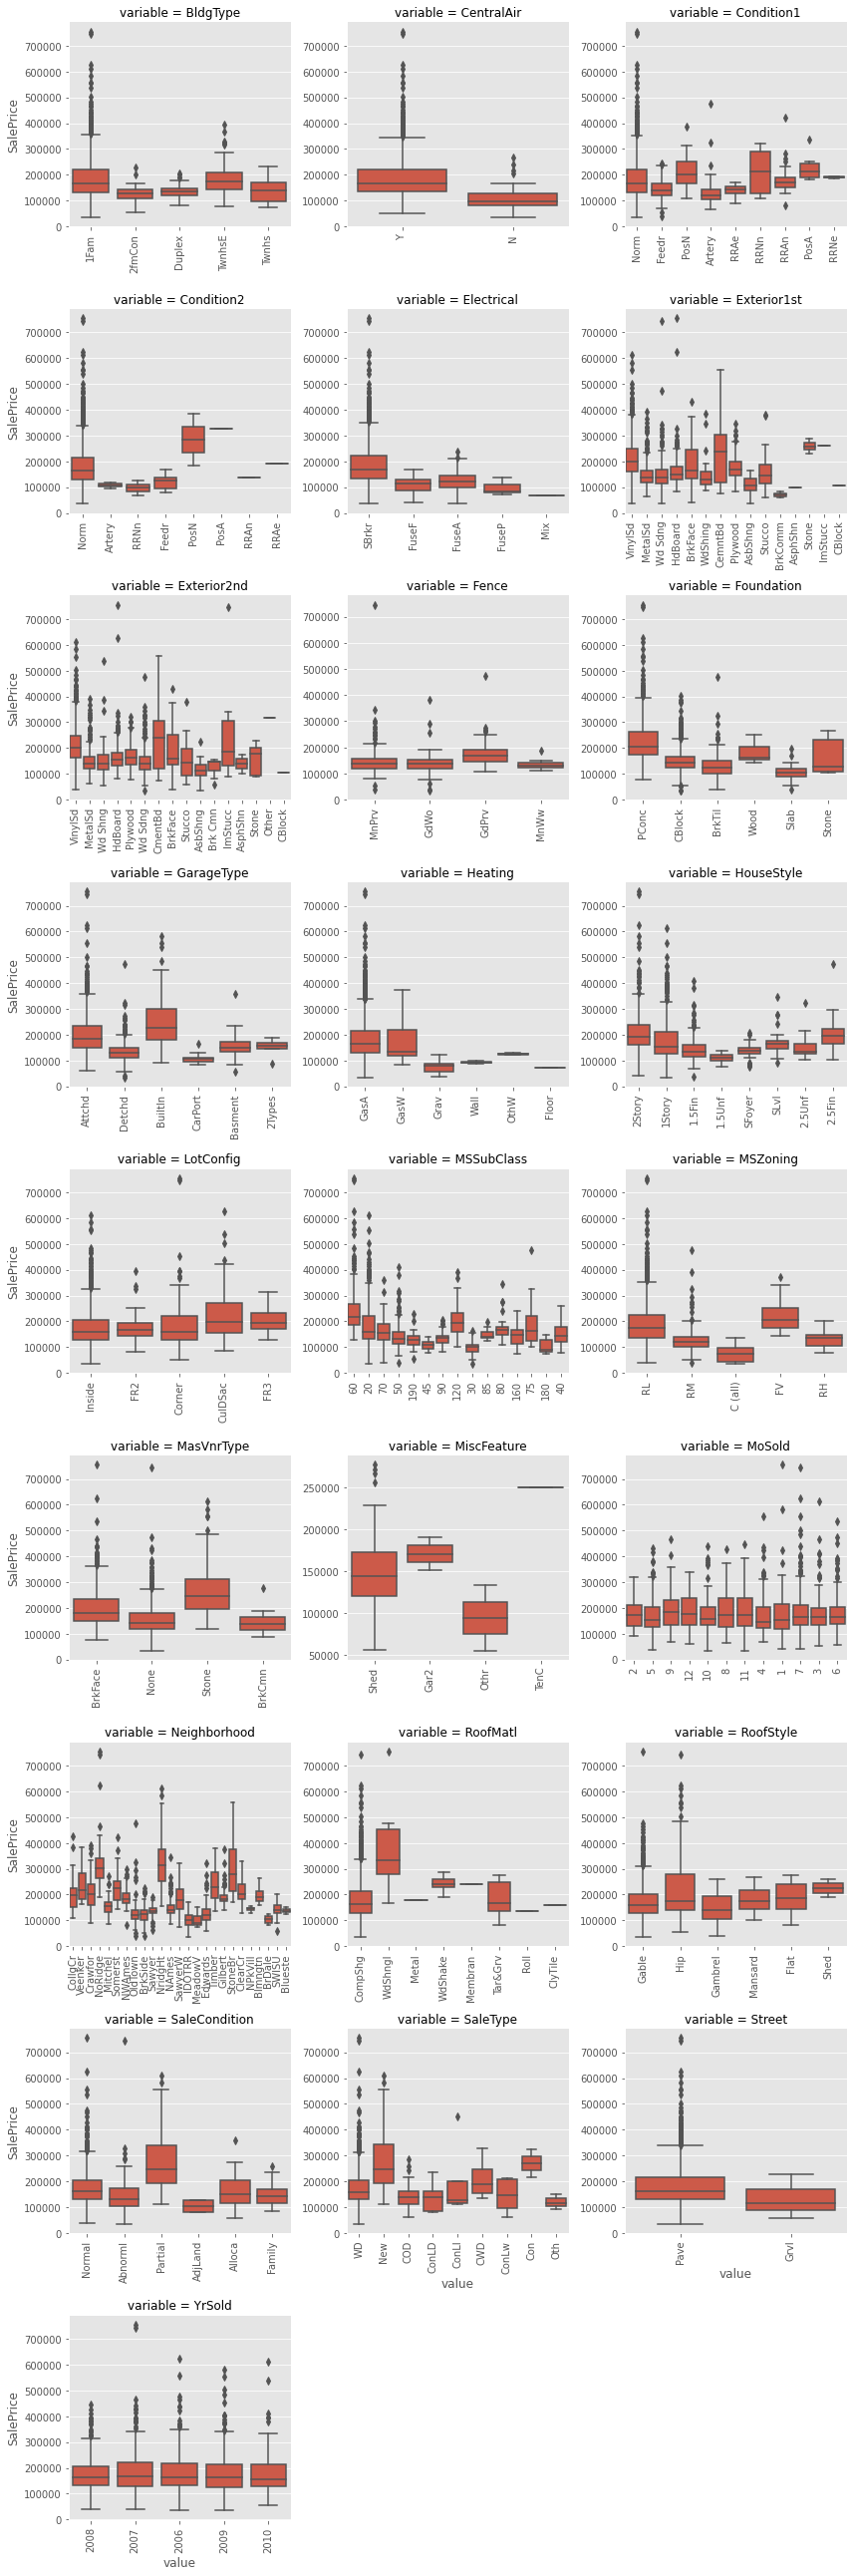

In [472]:
f = pd.melt(train, id_vars=['SalePrice'], value_vars=sorted(cat_features))
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False, size=4)
g = g.map(sns.boxplot, 'value', 'SalePrice')
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

## One Way ANOVA for all categorical variables

In [473]:
# In order for ANOVA to work, we have to take care of missing values first
train[cat_features] = train[cat_features].fillna('Missing')

# Onward...
anova = {'feature':[], 'f':[], 'p':[]}
for cat in cat_features:
    group_prices = []
    for group in train[cat].unique():
        group_prices.append(train[train[cat] == group]['SalePrice'].values)
    f, p = scipy.stats.f_oneway(*group_prices)
    anova['feature'].append(cat)
    anova['f'].append(f)
    anova['p'].append(p)
anova = pd.DataFrame(anova)
anova = anova[['feature','f','p']]
anova.sort_values('p', inplace=True)

anova['significant'] = anova['p'] < .05

display(anova)

,feature,f,p,significant
4,Neighborhood,71.784865,1.558600e-225,True
14,Foundation,100.253851,5.791895e-91,True
18,GarageType,80.379992,6.117026e-87,True
0,MSSubClass,33.732076,8.662166e-79,True
13,MasVnrType,84.672201,1.054025e-64,True
24,SaleCondition,45.578428,7.988268e-44,True
11,Exterior1st,18.611743,2.586089e-43,True
12,Exterior2nd,17.500840,4.842186e-43,True
23,SaleType,28.863054,5.039767e-42,True
1,MSZoning,43.840282,8.817634e-35,True


## There are a few things that are interesting here.

1. Neighborhood is by far the most significant with an astronomically low p-value in comparison to the others
2. There are only 3 Categorical Variables that are not significant, Street, MoSold, and YrSold. 
    - This is very interesting becasue as we saw previously, home sale prices appear to be seasonal in nature. Therefore, wouldn't the Year and Month Sold (more specifically the Month), have a significant effect on the mean sale price?

## Data Preprocessing and Regression

In [474]:
# ... and let's just get peace of mind for our data
print('Train set duplicate IDs: {}'.format(train.duplicated('Id').sum()))
print('Test set duplicate IDs: {}'.format(test.duplicated('Id').sum()))

Train set duplicate IDs: 0
Test set duplicate IDs: 0


## There are no duplicates, sick

In [475]:
# Categorical features with "Missing" values
missing_values = (train[cat_features] == 'Missing').sum().sort_values(ascending=False)
missing_values[missing_values > 0]

MiscFeature    1406
Fence          1179
GarageType       81
MasVnrType        8
Electrical        1
dtype: int64

## Lets evaluate what data we have that is missing. 
- As you'll recall, for the ANOVA test, we filled all of the NaN values with the string 'Missing'. Let's see how many times that occurred for each categorical variable

In [476]:
# Categorical features with "Missing" values
missing_values = (train[cat_features] == 'Missing').sum().sort_values(ascending=False)
missing_values[missing_values > 0]

MiscFeature    1406
Fence          1179
GarageType       81
MasVnrType        8
Electrical        1
dtype: int64

In [477]:
# Since there's only one missing Electrical, let's
# set it equal to the most common type
train.loc[train.Electrical == 'Missing', 'Electrical'] = train.Electrical.mode()[0]

In [478]:
# There's a tiny mistake that crept into our data.
# Unlike some other features, for MasVnrType "None" 
# was actually called out as an explicit value. 
# Now we have "None" and "Missing"
train.MasVnrType.value_counts()

# Let's change "Missing" to "None" here.
train.MasVnrType.replace({'Missing':'None'}, inplace=True)

train.loc[(train.MasVnrType == 'None') & (train.MasVnrArea > 1), 'MasVnrType'] = 'BrkFace' # most common 
train.loc[(train.MasVnrType == 'None') & (train.MasVnrArea == 1), 'MasVnrArea'] = 0 # 1 sq ft is basically 0
for vnr_type in train.MasVnrType.unique():
    # so here we set the area equal to the mean of the given veneer type
    train.loc[(train.MasVnrType == vnr_type) & (train.MasVnrArea == 0), 'MasVnrArea'] = \
        train[train.MasVnrType == vnr_type].MasVnrArea.mean() 

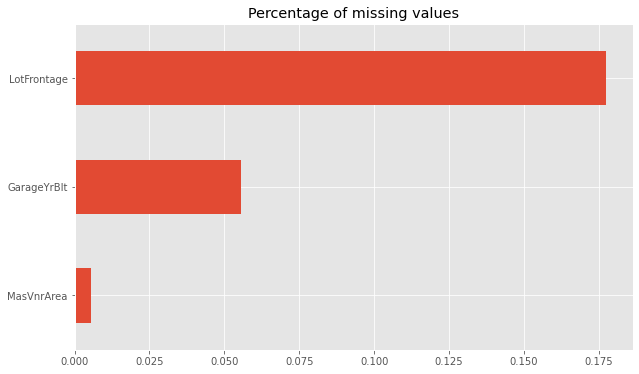

In [479]:
# Remaining missing values
missing_data = train.isnull().sum() / train.shape[0]
missing_data[missing_data > 0].\
    sort_values(ascending=True).\
    plot(kind='barh', figsize=(10,6))
plt.title('Percentage of missing values')
plt.show()

In [480]:
# LotFrontage is "Linear feet of street connected to property"
# Since it seems unlikely that there's no street connected
# to a lot, we'll set it equal to the median LotFrontage of that street.
train.LotFrontage = train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# MasVnrArea is "Masonry veneer area in square feet"
# This feature consists of a majority of 0 values, so 
# it's odd to find missing values here. Let's set to 0
train.MasVnrArea.fillna(0, inplace=True)

# Since GarageYrBlt missing means there's no garage
# we'll set it equal to 0
train.GarageYrBlt.fillna(0, inplace=True)

In [481]:
# Anything left?
train.isnull().sum().sum()

0

## Outliers

# From the Dataset Docs:

- There are 5 observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will indicate them quickly). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these 5 unusual observations) before assigning it to students.

Let's check that out

c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


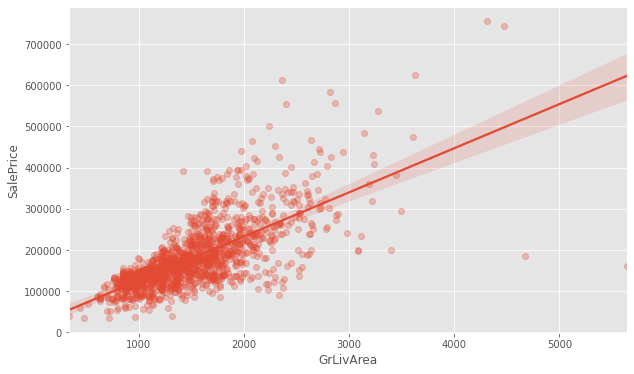

In [482]:
# First we visually inspect a scatter plot of GrLivArea vs. SalePrice
plt.figure(figsize=(10,6))
sns.regplot(train.GrLivArea, train.SalePrice, scatter_kws={'alpha':0.3})
plt.show()

c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


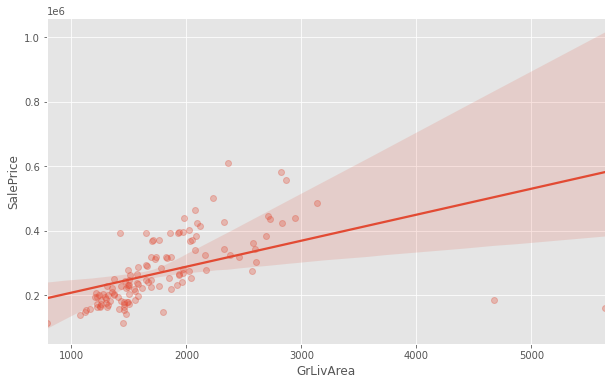

In [483]:
# We see the outliers but are also interested in those Partial Sale outliers
plt.figure(figsize=(10,6))
sns.regplot(train[train.SaleCondition == 'Partial'].GrLivArea,
            train[train.SaleCondition == 'Partial'].SalePrice, scatter_kws={'alpha':0.3})
plt.show()

In [484]:
# We heed the author's advice and cut out anything over 4,000 sq ft
train.drop(train[train.GrLivArea >= 4000].index, inplace=True)

# We just do what the author says here and cut out anything of 4000 sq ft

## Let's Create some more features from our existing features. A combination of features may prove to be better than the features themselves individually

In [485]:
# Total Square Footage
train['TotalSF'] = train.TotalBsmtSF + train.GrLivArea
train['TotalAbvGrdSF'] = train['1stFlrSF'] + train['2ndFlrSF']
train['TotalPorchSF'] = train.OpenPorchSF + train.EnclosedPorch + \
    train['3SsnPorch'] + train.ScreenPorch

In [486]:
# Total Bathrooms
train['TotalBathrooms'] = train.FullBath + .5 * train.HalfBath + \
    train.BsmtFullBath + .5 * train.BsmtHalfBath

In [487]:
# Booleans
train['HasBasement'] = train.TotalBsmtSF.apply(lambda x: 1 if x > 0 else 0)
train['HasGarage'] = train.GarageArea.apply(lambda x: 1 if x > 0 else 0)
train['HasPorch'] = train.TotalPorchSF.apply(lambda x: 1 if x > 0 else 0)
train['HasPool'] = train.PoolArea.apply(lambda x: 1 if x > 0 else 0)
train['WasRemodeled'] = (train.YearRemodAdd != train.YearBuilt).astype(np.int64)
train['IsNew'] = (train.YearBuilt > 2000).astype(np.int64)
train['WasCompleted'] = (train.SaleCondition != 'Partial').astype(np.int64)

boolean_features = ['HasBasement', 'HasGarage', 'HasPorch', 'HasPool', 
                    'WasRemodeled', 'IsNew', 'WasCompleted']

In [488]:
num_features, cat_features = get_feature_groups()
num_features = [f for f in num_features if f not in boolean_features]

## Transforms

In [489]:
print(len(num_features))

58


In [490]:
## Let's log transform any features that have a skew of more than .5

skewed_num_features = []

for feature in num_features:
    if train[feature].skew() > .5:
        skewed_num_features.append(feature)

print('Skewed Features:',skewed_num_features)
print('Number of Skewed Features:',len(skewed_num_features))

for feature in skewed_num_features:
    train[feature] = np.log1p(train[feature])

## Also Transform Sale Price
train['SalePrice'] = np.log1p(train['SalePrice'])

Skewed Features: ['LotFrontage', 'LotArea', 'Alley', 'LotShape', 'OverallCond', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'TotalSF', 'TotalAbvGrdSF', 'TotalPorchSF']
Number of Skewed Features: 34


## Out of all of our numerical features, excluding SalePrice, we have log transformed 34 of the features as they had a skewness of more than 0.5. Those features are listed above. We also log transfomed Sale Price

## Dummy Variables

In [491]:
# before we continue, let's drop some cols
y = train['SalePrice']
train.drop('SalePrice', axis=1, inplace=True)
train.drop('Id', axis=1, inplace=True)

In [492]:
# ... and go
model_data = pd.get_dummies(train).copy()

display(model_data)
display(y)

,LotFrontage,LotArea,Alley,LotShape,LandContour,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.189655,9.042040,0.0,0.693147,4,4,3,7,1.791759,2003,...,0,0,0,1,0,0,0,0,1,0
1,4.394449,9.169623,0.0,0.693147,4,4,3,6,2.197225,1976,...,0,0,0,1,0,0,0,0,1,0
2,4.234107,9.328212,0.0,1.098612,4,4,3,7,1.791759,2001,...,0,0,0,1,0,0,0,0,1,0
3,4.110874,9.164401,0.0,1.098612,4,4,3,7,1.791759,1915,...,0,0,0,1,1,0,0,0,0,0
4,4.442651,9.565284,0.0,1.098612,4,4,3,8,1.791759,2000,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,4.143135,8.976894,0.0,0.693147,4,4,3,6,1.791759,1999,...,0,0,0,1,0,0,0,0,1,0
1456,4.454347,9.486152,0.0,0.693147,4,4,3,6,1.945910,1978,...,0,0,0,1,0,0,0,0,1,0
1457,4.204693,9.109746,0.0,0.693147,4,4,3,7,2.302585,1941,...,0,0,0,1,0,0,0,0,1,0
1458,4.234107,9.181735,0.0,0.693147,4,4,3,5,1.945910,1950,...,0,0,0,1,0,0,0,0,1,0


0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1456, dtype: float64

## Standardization

In [493]:
# Split data intro train and validation sets
X_train, X_test, y_train, y_test = train_test_split(model_data.copy(), y, test_size=0.3, random_state=42)
print('Shapes')
print('X_train:', X_train.shape)
print('X_val:', X_test.shape)
print('y_train:', y_train.shape)
print('y_val:', y_test.shape)

Shapes
X_train: (1019, 263)
X_val: (437, 263)
y_train: (1019,)
y_val: (437,)


In [494]:
rbstsc = RobustScaler()

X_train.loc[:,num_features] = rbstsc.fit_transform(X_train[num_features])
X_test.loc[:,num_features] = rbstsc.transform(X_test[num_features])

y_train = rbstsc.transform(y_train)
y_test = rbstsc.transform(y_test)

display(y_train)

ValueError: Expected 2D array, got 1D array instead:
array=[11.72804491 12.15478461 11.51293546 ... 11.84940484 11.93164238
 12.27839796].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

## Modeling

In [ ]:
def model_evaluation_plots(model, X_train, y_train, X_test, y_test):
    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_test)
    
    plt.figure(figsize=(12,6))
    # Residuals
    plt.subplot(121)
    plt.scatter(y_train_preds, y_train_preds - y_train, c='blue', marker='o', label='Training data')
    plt.scatter(y_test_preds, y_test_preds - y_test, c='orange', marker='s', label='Validation data')
    plt.title('Residuals')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=y_train.min(), xmax=y_train.max(), color='red')

    # Predictions
    plt.subplot(122)
    plt.scatter(y_train_preds, y_train, c='blue', marker='o', label='Training data')
    plt.scatter(y_test_preds, y_test, c='orange', marker='s', label='Validation data')
    plt.title('Predictions')
    plt.xlabel('Predicted values')
    plt.ylabel('Real values')
    plt.legend(loc='upper left')
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c='red')
    plt.tight_layout()
    plt.show()


## SLR WITH ALL OUR VARIABLES

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

df = pd.DataFrame({'Actual': np.expm1(y_test), 'Predicted': np.expm1(y_pred)})
df


,Actual,Predicted
497,184000.0,174865.078256
1264,181000.0,153985.181246
411,145000.0,131808.219585
1048,115000.0,141781.693991
1035,84000.0,80918.865775
...,...,...
323,126175.0,124410.648995
1289,281000.0,301691.437330
726,222000.0,265720.355858
539,272000.0,247323.203918


Mean Absolute Error: 13877.054915882776
Mean Squared Error: 368714702.4236587
Root Mean Squared Error: 19201.945277071765


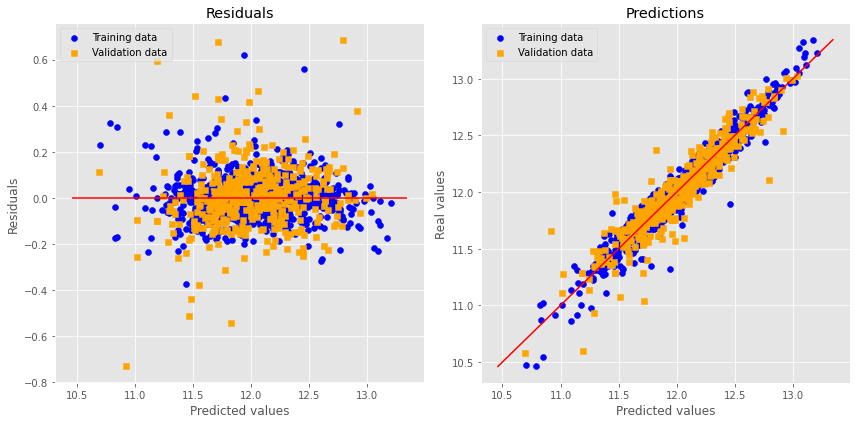

In [ ]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(np.expm1(y_test), np.expm1(y_pred)))  
print('Mean Squared Error:', metrics.mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.expm1(y_test), np.expm1(y_pred))))

model_evaluation_plots(lr, X_train, y_train, X_test, y_test)

## After inverse transforming the predicted values and their actual values, we can see that the RMSE for simple MLR is about 25,000. This isn't great, but not the worst. Now let's try with Ridge Regression.

,Actual,Predicted
497,184000.0,176416.531472
1264,181000.0,157136.114981
411,145000.0,137906.536386
1048,115000.0,137497.545649
1035,84000.0,79453.502240
...,...,...
323,126175.0,119801.790315
1289,281000.0,295285.212549
726,222000.0,264032.384524
539,272000.0,248900.246100


Mean Absolute Error: 13877.054915882776
Mean Squared Error: 368714702.4236587
Root Mean Squared Error: 19201.945277071765


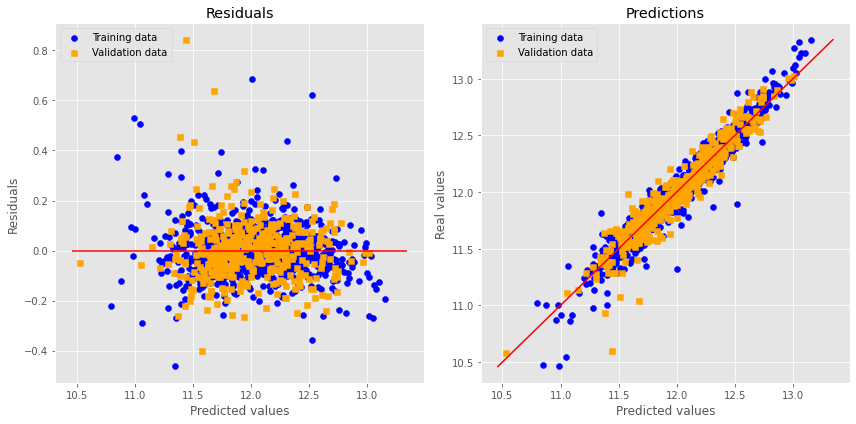

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# We're using GridSearch here to find the optimal alpha value
# Get the ballpark
param_grid = {'alpha': [0.01, 0.1, 1., 5., 10., 25., 50., 100.]}
ridge = GridSearchCV(Ridge(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
ridge.fit(X_train, y_train)
alpha = ridge.best_params_['alpha']

# Hone in
param_grid = {'alpha': [x/100. * alpha for x in range(50, 150, 5)]}
ridge = GridSearchCV(Ridge(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
ridge.fit(X_train, y_train)
alpha = ridge.best_params_['alpha']
ridge = ridge.best_estimator_

y_pred = ridge.predict(X_test)

df = pd.DataFrame({'Actual': np.expm1(y_test), 'Predicted': np.expm1(y_pred)})
display(df)

print('Mean Absolute Error:', metrics.mean_absolute_error(np.expm1(y_test), np.expm1(y_pred)))  
print('Mean Squared Error:', metrics.mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.expm1(y_test), np.expm1(y_pred))))

model_evaluation_plots(ridge, X_train, y_train, X_test, y_test)

## After inverse transforming the predicted values and their actual values, we can see that the RMSE for Ridge Regression with an alpha of 17.5 is 19,201. This isn't great, but not the worst. Now let's try with LASSO Regression.

Lasso(alpha=0.00055, max_iter=50000)


,Actual,Predicted
497,184000.0,175634.344381
1264,181000.0,155061.800189
411,145000.0,139524.607726
1048,115000.0,134101.051975
1035,84000.0,79990.270143
...,...,...
323,126175.0,120046.179828
1289,281000.0,294618.717820
726,222000.0,270898.509316
539,272000.0,249705.651713


Mean Absolute Error: 13700.64812844757
Mean Squared Error: 354224431.3232214
Root Mean Squared Error: 18820.850972345044


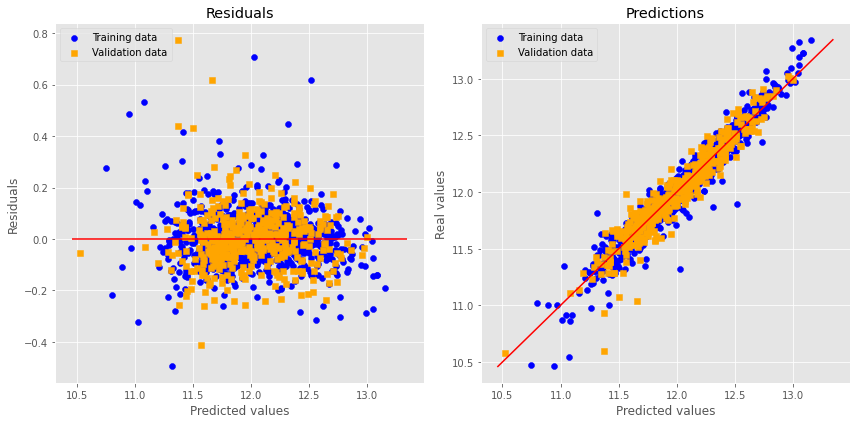

In [497]:
from sklearn.linear_model import Lasso

# We're using GridSearch here to find the optimal alpha value
# Get the ballpark
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1., 5., 10., 25.], 'max_iter': [50000]}
lasso = GridSearchCV(Lasso(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
lasso.fit(X_train, y_train)
alpha = lasso.best_params_['alpha']

# Hone in
param_grid = {'alpha': [x/100. * alpha for x in range(50, 150, 5)], 'max_iter': [50000]}
lasso = GridSearchCV(Lasso(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
lasso.fit(X_train, y_train)
alpha = lasso.best_params_['alpha']
lasso = lasso.best_estimator_

print(lasso)

y_pred = lasso.predict(X_test)

df = pd.DataFrame({'Actual': np.expm1(y_test), 'Predicted': np.expm1(y_pred)})
display(df)

print('Mean Absolute Error:', metrics.mean_absolute_error(np.expm1(y_test), np.expm1(y_pred)))  
print('Mean Squared Error:', metrics.mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.expm1(y_test), np.expm1(y_pred))))

model_evaluation_plots(lasso, X_train, y_train, X_test, y_test)

LASSO dropped 157 of 263 features.


c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


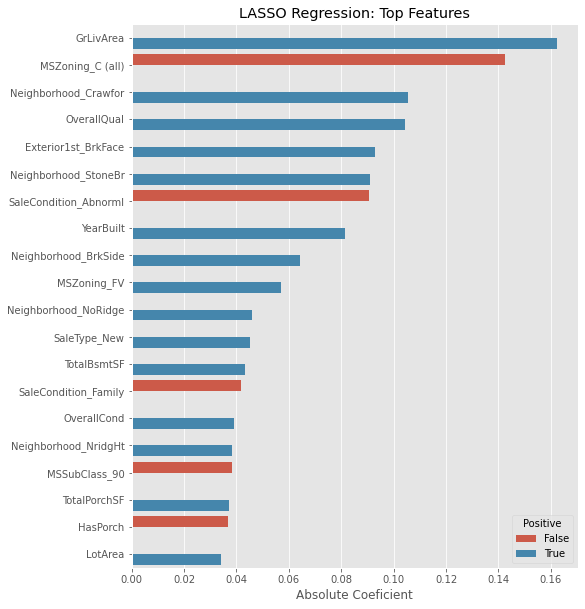

In [496]:
# Let's take a look at what the LASSO regression made of our features.
coefs = pd.DataFrame({'coefs':lasso.coef_,'Positive':lasso.coef_ > 0}, index=X_train.columns)
coefs['coefs_abs'] = np.abs(coefs.coefs)
print('LASSO dropped {} of {} features.'.format(
    sum(coefs.coefs == 0), coefs.shape[0]))

top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(20)
plt.figure(figsize=(8,10))
sns.barplot( top_coefs.coefs_abs, top_coefs.index, orient='h', hue=top_coefs.Positive)
plt.title('LASSO Regression: Top Features')
plt.xlabel('Absolute Coeficient')
plt.show()

## After inverse transforming the predicted values and their actual values, we can see that the RMSE for Ridge Regression with an alpha of .00055 is 19,201

- Additionally, the LASSO regression shrunk the number of variables from 263 Features to 106 features

In [511]:
## Get Un Normalized Data, as RandomForest Does not Require it

# Split data intro train and validation sets
# X_train, X_test, y_train, y_test = train_test_split(model_data.copy(), y, test_size=0.3, random_state=42)
# print('Shapes')
# print('X_train:', X_train.shape)
# print('X_val:', X_test.shape)
# print('y_train:', y_train.shape)
# print('y_val:', y_test.shape)

Shapes
X_train: (1019, 263)
X_val: (437, 263)
y_train: (1019,)
y_val: (437,)


,Actual,Predicted
497,12.122696,11.991199
1264,12.106258,12.133686
411,11.884496,11.835916
1048,11.652696,11.678597
1035,11.338584,11.366315
...,...,...
323,11.745433,11.765264
1289,12.546114,12.518714
726,12.310437,12.199203
539,12.513561,12.435381


Mean Absolute Error: 16238.201175787739
Mean Squared Error: 537433399.5967698
Root Mean Squared Error: 23182.609853007703


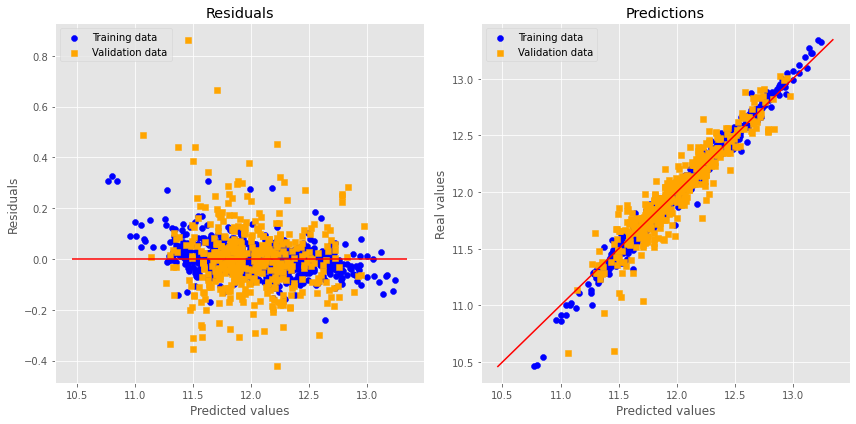

In [513]:
# from sklearn.ensemble import RandomForestRegressor
# random_forest = RandomForestRegressor()

# random_forest.fit(X_train, y_train)
# y_pred = random_forest.predict(X_test)

# df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# display(df)

# print('Mean Absolute Error:', metrics.mean_absolute_error(np.expm1(y_test), np.expm1(y_pred)))  
# print('Mean Squared Error:', metrics.mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))  
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.expm1(y_test), np.expm1(y_pred))))

# model_evaluation_plots(random_forest, X_train, y_train, X_test, y_test)